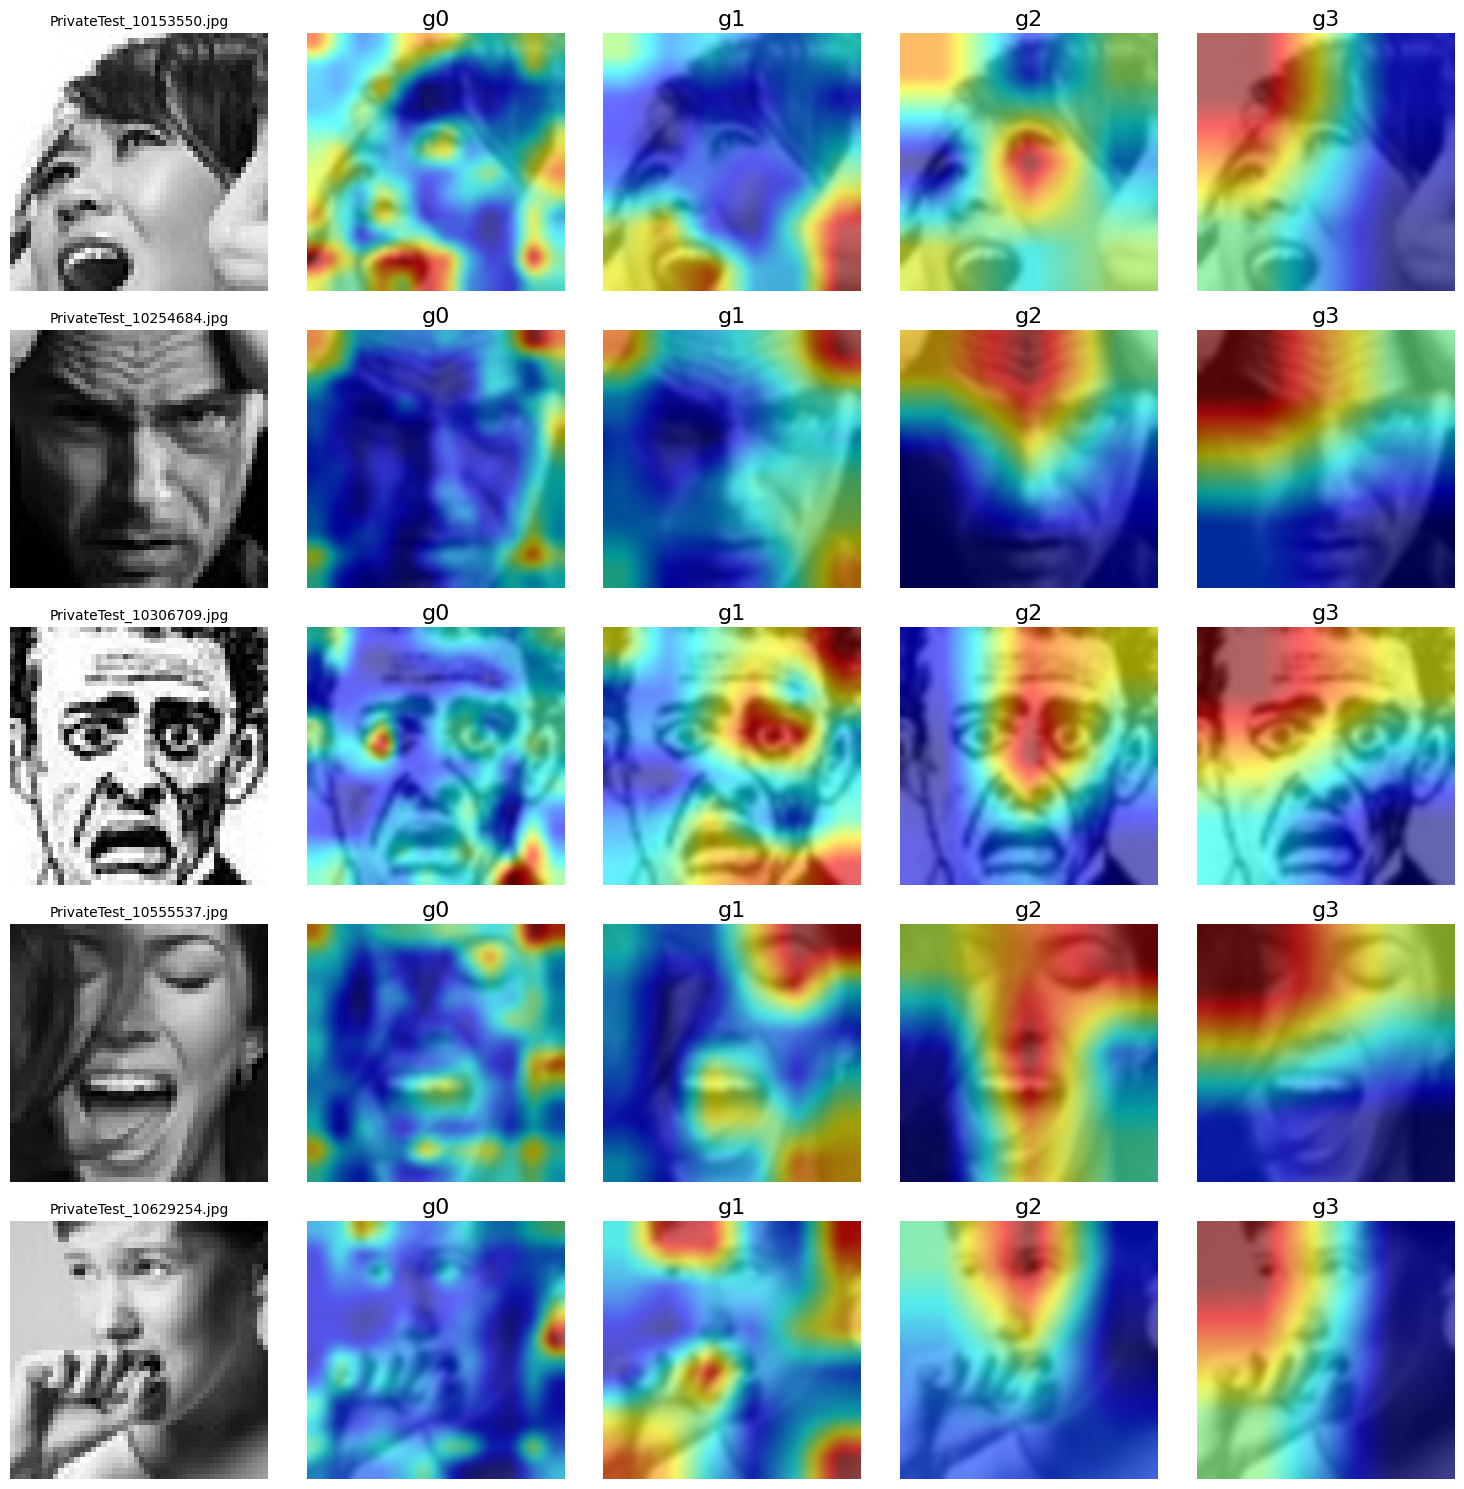

In [8]:
import os
import PIL
import cv2
from PIL import Image
import requests
import numpy as np
from io import BytesIO
import torch
from torch import nn
from torchvision.models import resnet34
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from gradcam.utils import Normalize

base_resnet = torch.load('models/best_model.pth')

class ResNetAT(ResNet):
    """Attention maps of ResNet-34.
    Overloaded ResNet model to return attention maps.
    """
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        g0 = self.layer1(x)
        g1 = self.layer2(g0)
        g2 = self.layer3(g1)
        g3 = self.layer4(g2)

        return [g.pow(2).mean(1) for g in (g0, g1, g2, g3)]

def generate_heatmap(g, original_img):
  g = cv2.resize(g.detach().numpy(), (original_img.shape[1], original_img.shape[0]))
  g = cv2.normalize(g, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  heatmap = cv2.applyColorMap(g, cv2.COLORMAP_JET)[:,:,::-1]
  blended_img = cv2.addWeighted(heatmap, 0.6, original_img, 0.4, 0)
  return blended_img

def load_imgs(num, img_dir):
    images_tensor = []
    images_numpy = []
    file_names=[]

    files = os.listdir(img_dir)
    files = sorted(files)

    for i in range(num):
        file_name = files[i]
        file_path = os.path.join(img_dir, file_name)
        file_names.append(file_name)

        img = Image.open(file_path)
        img_numpy = np.asarray(img)
        rgb_np = np.expand_dims(img_numpy, axis=-1)
        rgb_np = np.concatenate((rgb_np, rgb_np, rgb_np), axis=-1)
        images_numpy.append(rgb_np)

        normalizer = Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
        torch_img = torch.from_numpy(rgb_np).permute(2, 0, 1).unsqueeze(0).float().div(255)
        normed_torch_img = normalizer(torch_img)
        images_tensor.append(normed_torch_img)

    return images_tensor, images_numpy, file_names

if __name__ == '__main__':
    # 18
    # model = ResNetAT(BasicBlock, [2, 2, 2, 2])

    # 34
    model = ResNetAT(BasicBlock, [3, 4, 6, 3])

    model.fc = nn.Linear(in_features=512, out_features=7)
    model.load_state_dict(base_resnet)

    num = 5
    images_tensor, images_numpy, names = load_imgs(num=num, img_dir='data/test/fear')

    fig, axes = plt.subplots(num, 5, figsize=(15, 15))

    for id, image_tensor, image_numpy in zip(range(num), images_tensor, images_numpy):
        model.eval()
        with torch.no_grad():
            image_tensor = image_tensor.expand(-1, 3, -1, -1)
            x = image_tensor
            gs = model(x)

            axes[id,0].imshow(image_numpy, cmap='gray');
            axes[id,0].set_title(names[id], fontsize=10)
            axes[id,0].axis('off')

        for i, g in enumerate(gs):
            heat_map = generate_heatmap(g[0], image_numpy)

            axes[id,i+1].imshow(heat_map, interpolation='bicubic')
            axes[id,i+1].set_title(f'g{i}', fontsize=16)
            axes[id,i+1].axis('off')

    plt.tight_layout()
    plt.savefig('img/fear.png')
    plt.show()

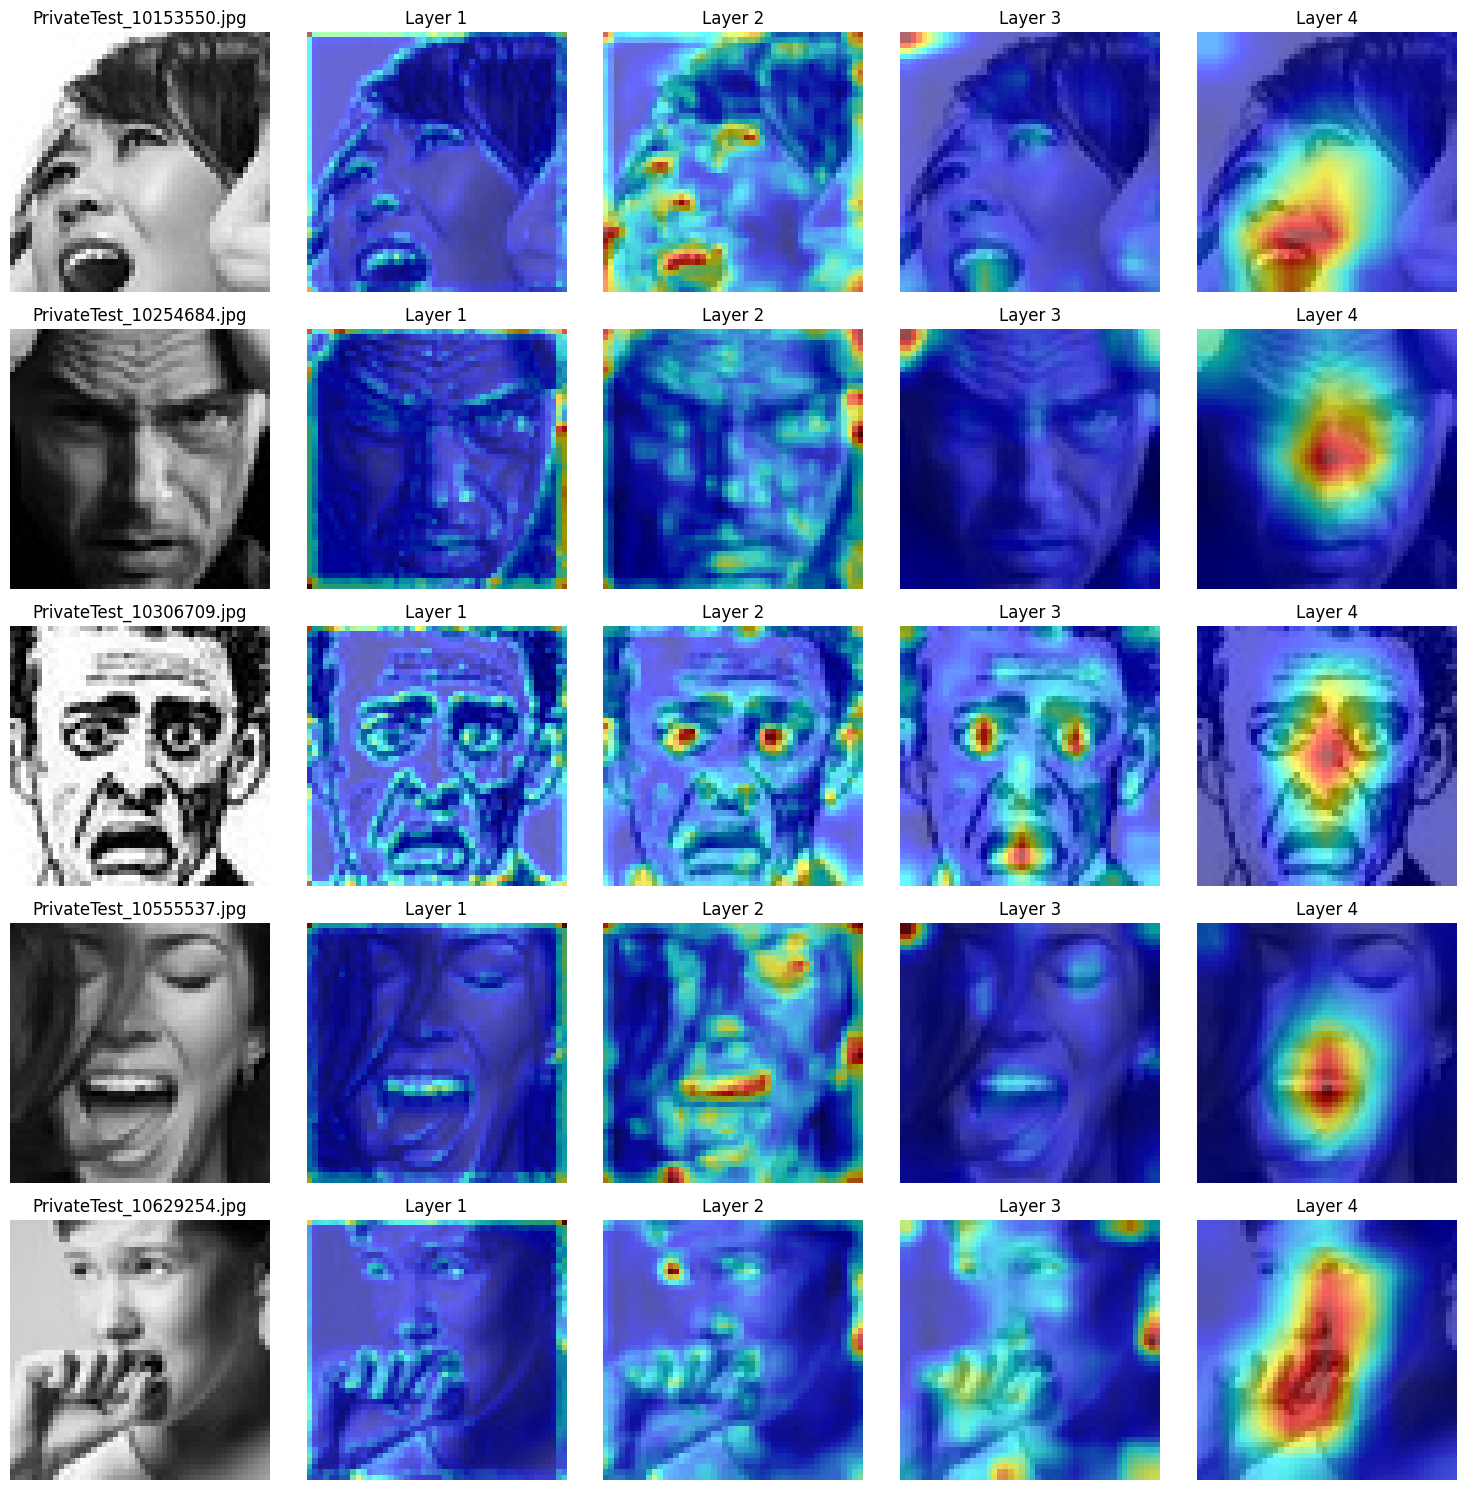

In [13]:
import os
import cv2
import numpy as np
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image

MODEL_PATH = 'models/best_model.pth'

class ResNetAT(models.ResNet):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNetAT, self).__init__(block, layers, num_classes=num_classes)
    
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        g0 = self.layer1(x)
        g1 = self.layer2(g0)
        g2 = self.layer3(g1)
        g3 = self.layer4(g2)

        return [g.pow(2).mean(1) for g in (g0, g1, g2, g3)]

def load_model(model_path=MODEL_PATH, device='cuda'):
    model = ResNetAT(models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=7)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    return model

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# def generate_heatmap(g, original_img):
#     g = cv2.resize(g, (original_img.shape[1], original_img.shape[0]))
#     g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     heatmap = cv2.applyColorMap(g, cv2.COLORMAP_JET)[:, :, ::-1]
#     blended_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
#     return blended_img

def generate_heatmap(g, original_img):
    g = cv2.resize(g, (original_img.shape[1], original_img.shape[0]))
    g = cv2.normalize(g, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap = cv2.applyColorMap(g, cv2.COLORMAP_JET)[:,:,::-1]
    blended_img = cv2.addWeighted(heatmap, 0.6, original_img, 0.4, 0)
    return blended_img

def visualize_attention(model, img_paths, device='cuda'):
    fig, axes = plt.subplots(len(img_paths), 5, figsize=(15, 3 * len(img_paths)))
    model.eval()
    
    for i, img_path in enumerate(img_paths):
        with torch.no_grad():
            img_tensor = preprocess_image(img_path).to(device)
            gs = model(img_tensor)

        original_img = cv2.imread(img_path)[:, :, ::-1]  # Convert BGR to RGB
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(os.path.basename(img_path))
        axes[i, 0].axis('off')

        for j, g in enumerate(gs):
            heatmap = generate_heatmap(g.cpu().squeeze().numpy(), original_img)
            axes[i, j + 1].imshow(heatmap)
            axes[i, j + 1].set_title(f'Layer {j + 1}')
            axes[i, j + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(device=device)
    
    img_dir = 'data/test/fear'  # Update this path to your images directory
    img_paths = [os.path.join(img_dir, img) for img in sorted(os.listdir(img_dir))][:5]  # Load first 5 images
    
    visualize_attention(model, img_paths, device=device)
